# Setup

In [43]:
import json
import os
import random
from typing import Tuple
import numpy as np
import pandas as pd
import wandb

from src.common import flatten, load_from_jsonl, save_to_jsonl
from src.models.openai_complete import OpenAIAPI
from src.wandb_utils import convert_runs_to_df

from src.tasks.reverse_experiments.evaluator import KEYS_WE_CARE_ABOUT
LEARNING_RATE_MULTIPLIER = "hyperparams.learning_rate_multiplier"
BATCH_SIZE = "hyperparams.batch_size"
CONFIGS_WE_CARE_ABOUT = ["model", "fine_tuned_model", LEARNING_RATE_MULTIPLIER, BATCH_SIZE]


if os.path.basename(os.getcwd()) != "situational-awareness":
    # move up two directories
    os.chdir("../..")

# Heatmap of performance for Ada sweep

In [13]:
def get_runs_df(project: str, keys_we_care_about=KEYS_WE_CARE_ABOUT, configs_we_care_about=CONFIGS_WE_CARE_ABOUT) -> pd.DataFrame:
    api = wandb.Api()
    runs = api.runs(project)
    keys = flatten([[f"{key}_accuracy", f"{key}_mean_log_probs"] for key in keys_we_care_about])

    return convert_runs_to_df(runs, keys, configs_we_care_about)

runs_df = get_runs_df("sita/reverse-experiments")

In [35]:
ada_sweep_model_names = ['ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12']

ada_sweep_df = runs_df[runs_df["fine_tuned_model"].isin(ada_sweep_model_names)]
ada_sweep_df['test_accuracy'] = (ada_sweep_df['p2d_prompts_test_accuracy'] + ada_sweep_df['d2p_prompts_test_accuracy']) / 2
ada_sweep_df['reverse_test_accuracy'] = (ada_sweep_df['p2d_reverse_prompts_test_accuracy'] + ada_sweep_df['d2p_reverse_prompts_test_accuracy']) / 2

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_21928/3479865559.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ada_sweep_df['test_accuracy'] = (ada_sweep_df['p2d_prompts_test_accuracy'] + ada_sweep_df['d2p_prompts_test_accuracy']) / 2
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_21928/3479865559.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ada_sweep_df['reverse_test_accuracy'] = (ada_sweep_df['p2d_reverse_prompts_test_accuracy'] + ada_sweep_df['d2p_reverse_prompts_tes

In [30]:
ada_sweep_df['d2p_reverse_prompts_test_accuracy'].values

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00333333, 0.00333333, 0.        , 0.00666667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00666667,
       0.        , 0.        , 0.        , 0.        , 0.        ])

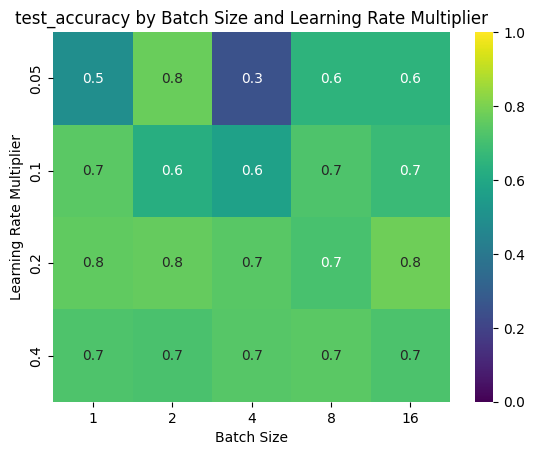

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_heatmap(results_df: pd.DataFrame, metric: str):
    """Plot heatmap where the x-axis is the batch_size and the y-axis is the learning rate multiplier."""
    # use pivot table to get the data in the right format
    results_df = results_df.pivot_table(index=LEARNING_RATE_MULTIPLIER, columns=BATCH_SIZE, values=metric)
    results_df = results_df.sort_index(ascending=False)
    
    # plot the heatmap
    ax = sns.heatmap(results_df, annot=True, fmt=".1f", cmap="viridis", vmin=0, vmax=1)
    ax.invert_yaxis()
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate Multiplier")
    ax.set_title(f"{metric} by Batch Size and Learning Rate Multiplier")
    plt.show()

# plot_heatmap(ada_sweep_df, "both_prompts_test_accuracy")

plot_heatmap(ada_sweep_df, "test_accuracy")

We see that the best combination of learning rate and batch size is 0.2 and 16.

In [62]:
# find best hyperparams
best_hyperparams = ada_sweep_df.sort_values("test_accuracy", ascending=False).iloc[0][[LEARNING_RATE_MULTIPLIER, BATCH_SIZE]]
best_hyperparams

hyperparams.learning_rate_multiplier    0.2
hyperparams.batch_size                   16
Name: 43, dtype: object

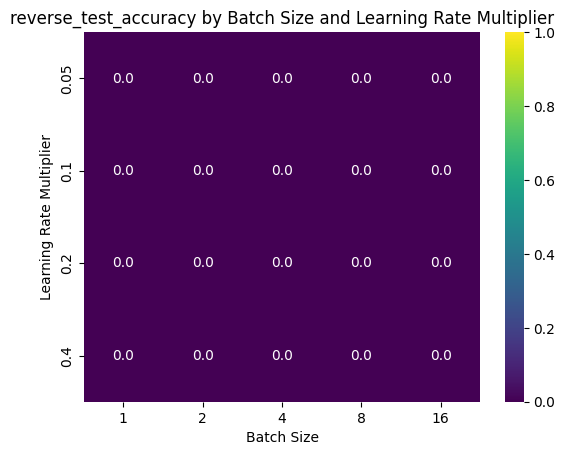

In [36]:
plot_heatmap(ada_sweep_df, "reverse_test_accuracy")

# Comparison of logits for correct vs incorrect values

In [56]:
from scipy.stats import ttest_rel

def get_target_logprobs(model, file):
    """For each example, get the logprobs of each completion."""
    examples = load_from_jsonl(file)
    targets = list(set([example["completion"] for example in examples]))

    logprobs = model.cond_log_prob([example["prompt"] for example in examples], [[example["completion"], random.choice(targets)] for example in examples])

    return pd.DataFrame(logprobs, columns=["correct", "random"])


def test_if_correct_answer_has_higher_log_probs(model, file):
    target_logprobs = get_target_logprobs(model, file)
    examples = load_from_jsonl(file)

    # do hypothesis test to see if the mean of these two populations are different
    

    t, p = ttest_rel(target_logprobs["correct"], target_logprobs["random"], alternative="greater")
    return t, p, target_logprobs["correct"].mean(), target_logprobs["random"].mean()

In [57]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]
model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")


Mean logprob of correct answer: -1.6596894739754584
Mean logprob of random answer: -1.1955028554345484
p-value: 0.9952397111639056


In [58]:
from tqdm import tqdm


ttest_df = pd.DataFrame(columns=["model_name", "t_stat", "p_value", "mean_correct", "mean_random"])

for model_name in tqdm(ada_sweep_df["fine_tuned_model"]):
    model = OpenAIAPI(model_name)
    t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
    ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True)

ttest_df


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_21928/1144615985.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True)
  5%|▌         | 1/20 [00:04<01:24,  4.45s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_21928/1144615985.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True)
 10%|█         | 2/20 [00:10<01:37,  5.40s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_21928/1144615985.py:9: FutureWarning:

,model_name,t_stat,p_value,mean_correct,mean_random
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-2.433940,0.992240,-1.642677,-1.210890
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.410137,0.659000,-1.429702,-1.356093
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-2.911836,0.998068,-1.726718,-1.189713
3,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.094219,0.537501,-1.559517,-1.540519
4,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.310684,0.621871,-1.553775,-1.492213
5,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-3.032309,0.998680,-1.766961,-1.196074
6,ada:ft-dcevals-kokotajlo:reverse-june-version-...,1.418537,0.078538,-1.350277,-1.617879
7,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.937088,0.825265,-1.492696,-1.327400
8,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.272978,0.392529,-1.539748,-1.594654
9,ada:ft-dcevals-kokotajlo:reverse-june-version-...,1.840454,0.033346,-1.262663,-1.597159


# Sanity check: Making sure logits are higher for non-reverse task

In [59]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]
model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/d2p_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")

Mean logprob of correct answer: -0.03732340813195372
Mean logprob of random answer: -17.076670149366553
p-value: 3.913045057759599e-138
